In [911]:
import pandas as pd
import numpy as np
import pyperclip as pc
import requests
import kaggle

# ________________________________________
from urllib.request import urlopen
from urllib.error import HTTPError
from bs4 import BeautifulSoup

# ____________________________________________________________________
from scipy import stats
from statsmodels.stats import proportion
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import chart_studio.plotly as py
import cufflinks as cf
import datetime as dt

#_____________________________________________________________________
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

from joblib import Parallel, delayed
import multiprocessing
from IPython.display import display, clear_output
import plotly.tools as tls
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import json
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

#___________________________________________________________________
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)
cf.go_offline()

# tls.set_credentials_file(username='marcelofprado', api_key='cftsFWfYZ7DgpGQtDuRe')
# init_notebook_mode(connected=True)

np.seterr(divide='ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [912]:
def conf_int(count, nobs, alpha = 0.05, method = 'binom_test'):
    try:
        a = proportion.proportion_confint(count = count, nobs = nobs, alpha = alpha, method = method)
    except ValueError:
        a = [0, 0]
    return a

resp = pd.read_csv('resp.csv')
resp.columns = ['state', 'equipments']
resp_sum = resp['equipments'].sum()
resp = resp.set_index('state', drop = True)

hh = 18
str_today = (dt.date.today() - dt.timedelta(hours=hh)).strftime('%Y-%m-%d')
str_cases = (dt.date.today() - dt.timedelta(days=13)).strftime('%Y-%m-%d')

state_dict = {
    'AC': 'Acre',
    'AL': 'Alagoas',
    'AP': 'Amapá',
    'AM': 'Amazonas',
    'BA': 'Bahia',
    'CE': 'Ceará',
    'DF': 'Distrito Federal',
    'ES': 'Espírito Santo',
    'GO': 'Goiás',
    'MA': 'Maranhão',
    'MT': 'Mato Grosso',
    'MS': 'Mato Grosso do Sul',
    'MG': 'Minas Gerais',
    'PA': 'Pará',
    'PB': 'Paraíba',
    'PR': 'Paraná',
    'PE': 'Pernambuco',
    'PI': 'Piauí',
    'RJ': 'Rio de Janeiro',
    'RN': 'Rio Grande do Norte',
    'RS': 'Rio Grande do Sul',
    'RO': 'Rondônia',
    'RR': 'Roraima',
    'SC': 'Santa Catarina',
    'SP': 'São Paulo',
    'SE': 'Sergipe',
    'TO': 'Tocantins'
}

region_dict = {
    'AC': 'N',
    'AL': 'NE',
    'AP': 'N',
    'AM': 'N',
    'BA': 'NE',
    'CE': 'NE',
    'DF': 'CO',
    'ES': 'SE',
    'GO': 'CO',
    'MA': 'NE',
    'MT': 'CO',
    'MS': 'CO',
    'MG': 'SE',
    'PA': 'N',
    'PB': 'NE',
    'PR': 'S',
    'PE': 'NE',
    'PI': 'NE',
    'RJ': 'SE',
    'RN': 'NE',
    'RS': 'S',
    'RO': 'N',
    'RR': 'N',
    'SC': 'S',
    'SP': 'SE',
    'SE': 'NE',
    'TO': 'N'
}

char_dict = {
    'Á': 'A',
    'É': 'E',
    'Í': 'I',
    'Ó': 'O',
    'Ú': 'U',
    'Ã': 'A',
    'Õ': 'O',
    'Ç': 'C',
    'Â': 'A',
    'Ê': 'E',
    'Ô': 'O'
}

inv_state_dict = {v: k for k, v in state_dict.items()}

In [913]:
url = 'https://pt.wikipedia.org/wiki/Estat%C3%ADsticas_da_pandemia_de_COVID-19_no_Brasil'
html = urlopen(url)
soup = BeautifulSoup(html, 'html.parser')

In [914]:
table = soup.find_all('table')[2]
rows = table.find_all('tr')
header = table.find_all('th')

result = []
h = []
for item in header:
    h.append(item.get_text().replace('\n',''))

for row in rows:
    items = row.find_all('td')
    a = []
    for item in items:
        cont = item.get_text().replace('\n','')
        a.append(cont)
    result.append(a)
    
    
df_result = pd.DataFrame(result)
df_result.columns = h
df_result['date'] = str_today
df_result = df_result.loc[1:]
df_result['Unidade federativa'] = df_result['Unidade federativa'].str.replace('  ', ' ')
# print(h)
df_result.to_csv('./scrapping/' + str_today + '_city_cases.csv')
df_result.columns = ['city', 'UF', 'cases', 'population', 'cases_per_million', 'date']
df_result['state'] = df_result['UF'].replace(inv_state_dict)
df_result['city'] = df_result['city'].str.upper()
df_result['cases'] = df_result['cases'].str.replace('\xa0425','').astype(float)

for old, new in char_dict.items():
    df_result['city'] = df_result['city'].str.replace(old,new)
    
print(len(df_result))
# df_result

567


In [915]:
df_cities_biz = pd.read_csv('20200402_cities_biz.csv')
df_cities_biz['region'] = df_cities_biz['state'].replace(region_dict)
df_cities_biz = df_cities_biz.dropna()
df_biz_cases = df_cities_biz.merge(df_result[['cases', 'city', 'state']], on = ['city', 'state'], how = 'left').fillna(0)
df_biz_cases['flag_cases'] = (df_biz_cases['cases'] > 0)
pt_biz = df_biz_cases.pivot_table(values = 'cases', index = 'region', columns = 'flag_cases', aggfunc = 'count')
pt_biz.loc['Brasil'] = pt_biz.sum()
df_result_all = pt_biz.div(pt_biz.sum(axis = 1), axis = 0) * 100
df_result_all['avg_cases'] = df_biz_cases.groupby('region').mean()['cases']
gp_df_cities_biz = df_cities_biz.groupby('region').sum()
gp_df_cities_biz.loc['Brasil'] = gp_df_cities_biz.sum()
gp_df_cities_biz_div = gp_df_cities_biz.div(gp_df_cities_biz.sum(axis = 1), axis = 0) * 100
df_result_all = df_result_all.merge(gp_df_cities_biz_div, on = 'region')
# df_result.sort_values(by = True, ascending = False)
df_result_all

False   True  avg_cases  comercio  industria  servicos  agro  \
region                                                                 
CO     76.033 23.967      5.686    43.620      7.715    43.175 0.445   
N      74.227 25.773      6.175    60.181      4.977    29.638 0.679   
NE     75.484 24.516      5.365    45.135      8.378    40.450 0.270   
S      50.222 49.778      5.111    41.294     11.703    40.913 0.761   
SE     64.501 35.499      5.487    39.218      7.409    48.644 0.252   
Brasil 66.639 33.361        nan    42.472      8.141    44.100 0.388   

        construcao  
region              
CO           5.045  
N            4.525  
NE           5.766  
S            5.328  
SE           4.477  
Brasil       4.900

In [916]:
url = 'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-' + str_today + '.xlsx'
# file = requests.get(url)
world_data = pd.read_excel(url)
world_data.columns = ['date', 'day', 'month', 'year', 'cases', 'deaths', 'country', 'country_geoid', 'country_code', 'population']
print(str_cases + " - " + str_today)
# world_data.head(5)

2020-03-24 - 2020-04-06


In [917]:
pt_world_data = world_data.pivot_table(values = 'cases', index = 'country', columns = 'date', aggfunc = sum)
pt_world_daily = pt_world_data.copy()
pt_world_data = pt_world_data.cumsum(axis = 1)
pt_world_data = pt_world_data[pt_world_data[str_today] > 1000].sort_values(by=str_today, ascending = False)

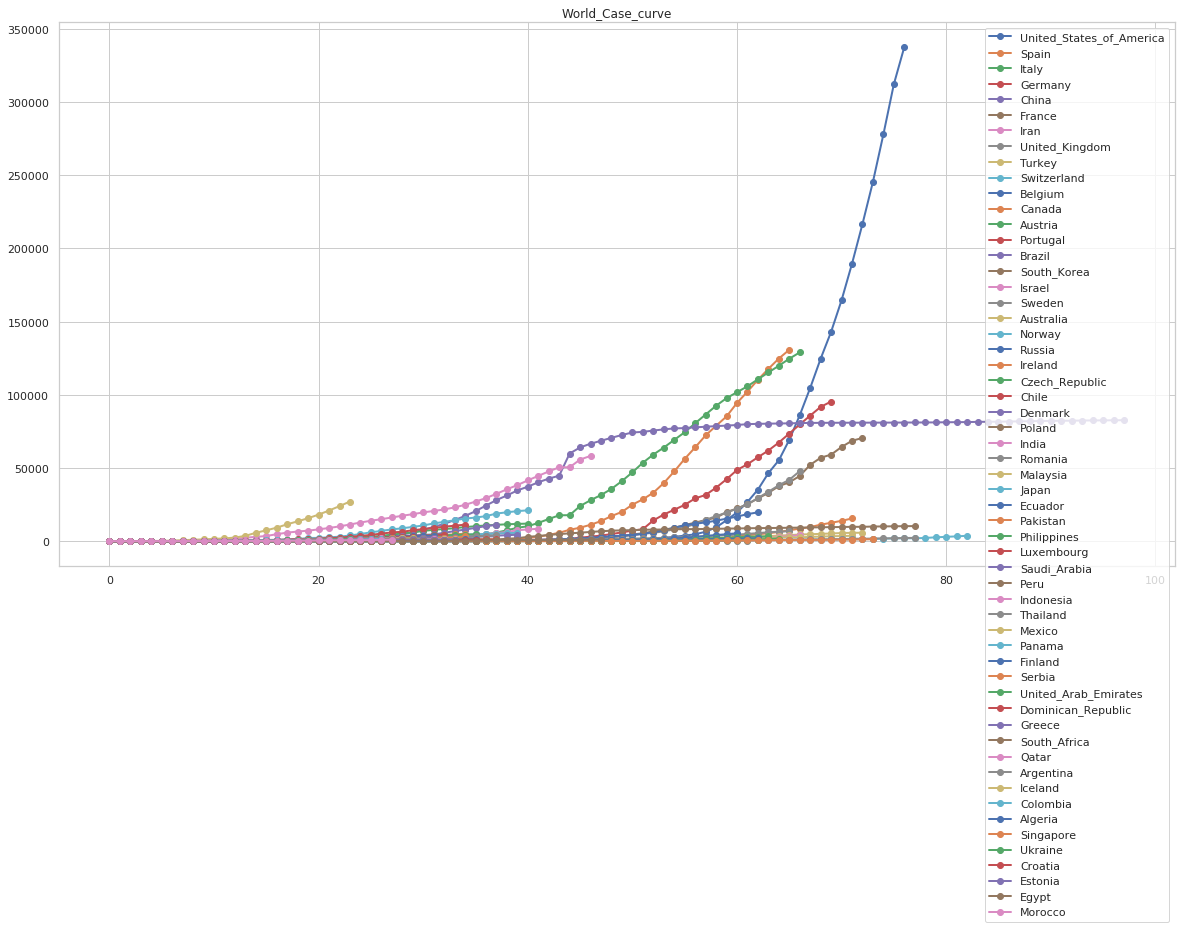

In [918]:
df = pd.DataFrame()
for i in pt_world_data.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
plt.figure(figsize = (20,10))
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}

plt.rc('font', **font)
title = 'World_Case_curve'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
    plt.legend()
    
plt.savefig('./img/' + title)

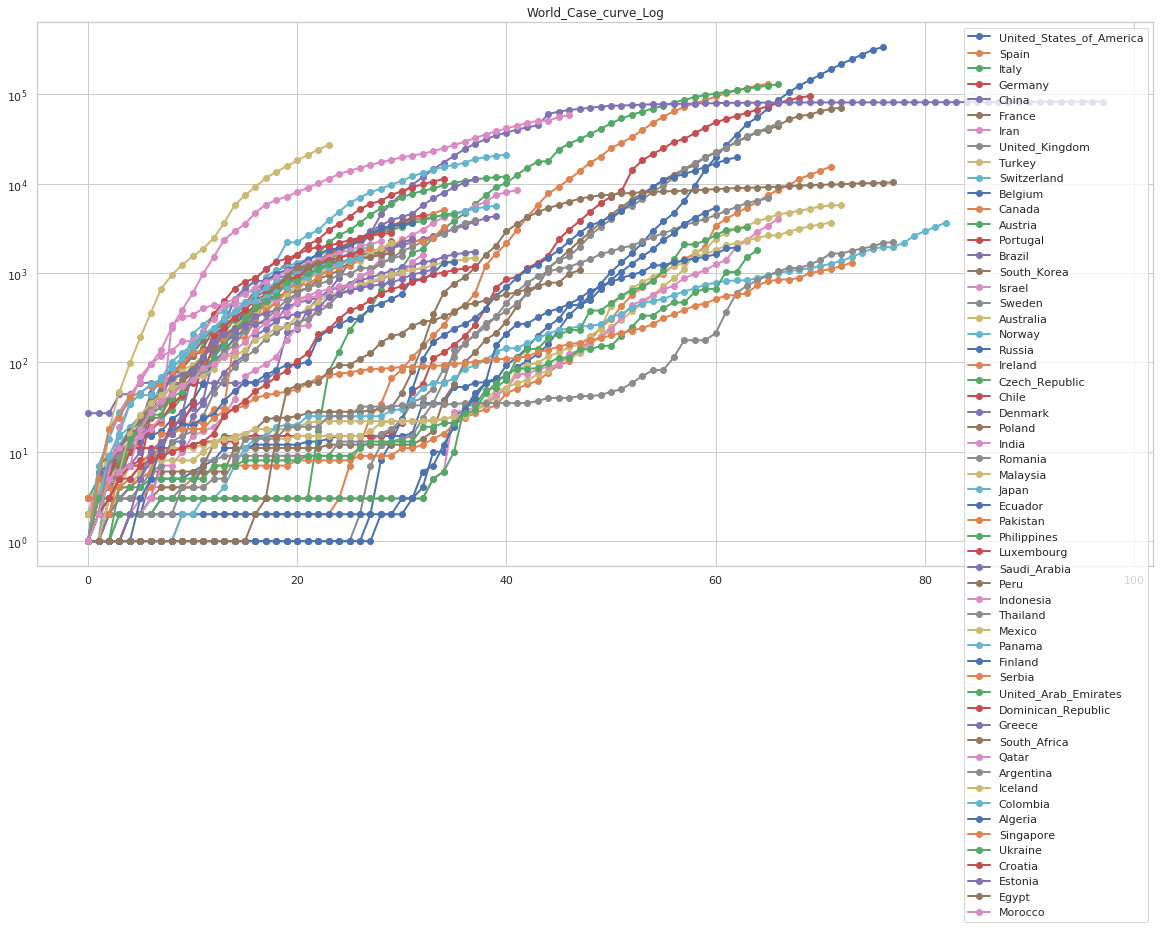

In [919]:
df = pd.DataFrame()
for i in pt_world_data.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
plt.figure(figsize = (20,10))

plt.rc('font', **font)
plt.yscale('log')
title = 'World_Case_curve_Log'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
    plt.legend()
    
plt.savefig('./img/' + title)

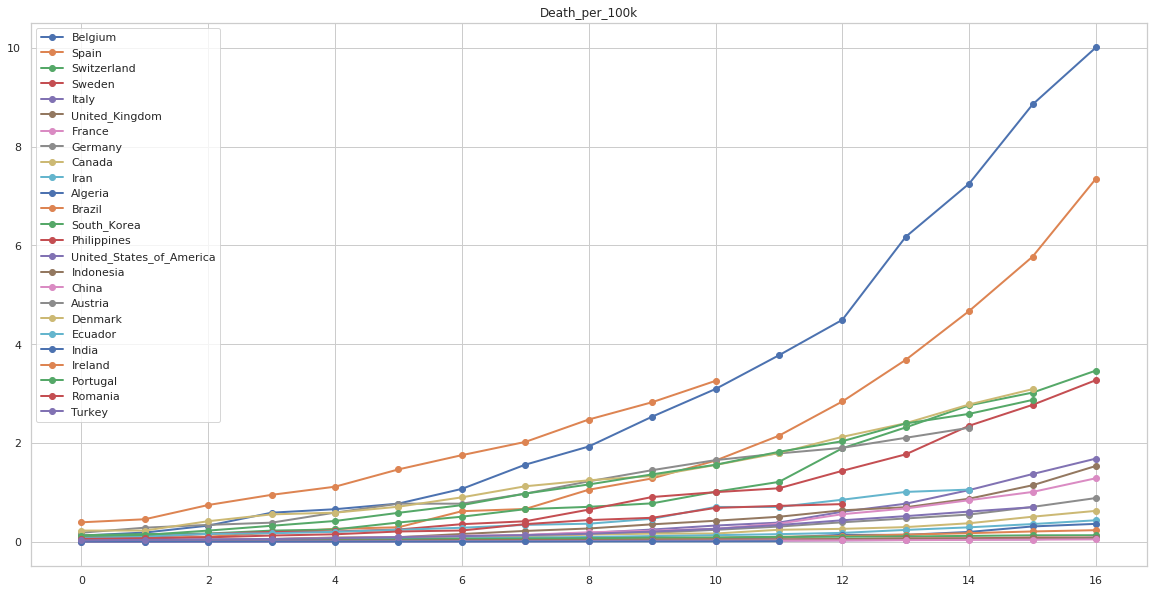

In [920]:
pt_world_data_deaths = world_data.pivot_table(values = 'deaths', index = 'country', columns = 'date', aggfunc = sum).cumsum(axis = 1)
pt_world_data_deaths = pt_world_data_deaths[pt_world_data_deaths[str_today] > 100]
pt_world_data_pop = world_data.pivot_table(values = 'population', index = 'country', columns = 'date', aggfunc = sum)
pt_world_data_pop = pt_world_data_pop[pt_world_data_pop[str_today] > 1000000]
pt_data = pt_world_data_deaths
pt_data = pt_data[~pt_data[str_today].isna()].sort_values(by=str_today, ascending = False)
df = pd.DataFrame()
for i in pt_data.iterrows():
    temp = i[1]
    temp = temp.loc[temp >= 10].reset_index(drop = True)
    df = df.append(temp)

df = (df.div(pt_world_data_pop[str_today], axis = 0) * 100000)
df = df[~df[0].isna()]
df = df[df.loc[['Brazil']].dropna(axis = 1).columns]
df = df.sort_values(by = len(df.columns) -1, ascending = False)
    
plt.figure(figsize = (20,10))

plt.rc('font', **font)
# plt.yscale('log')
title = 'Death_per_100k'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
    plt.legend()
    
plt.savefig('./img/' + title)



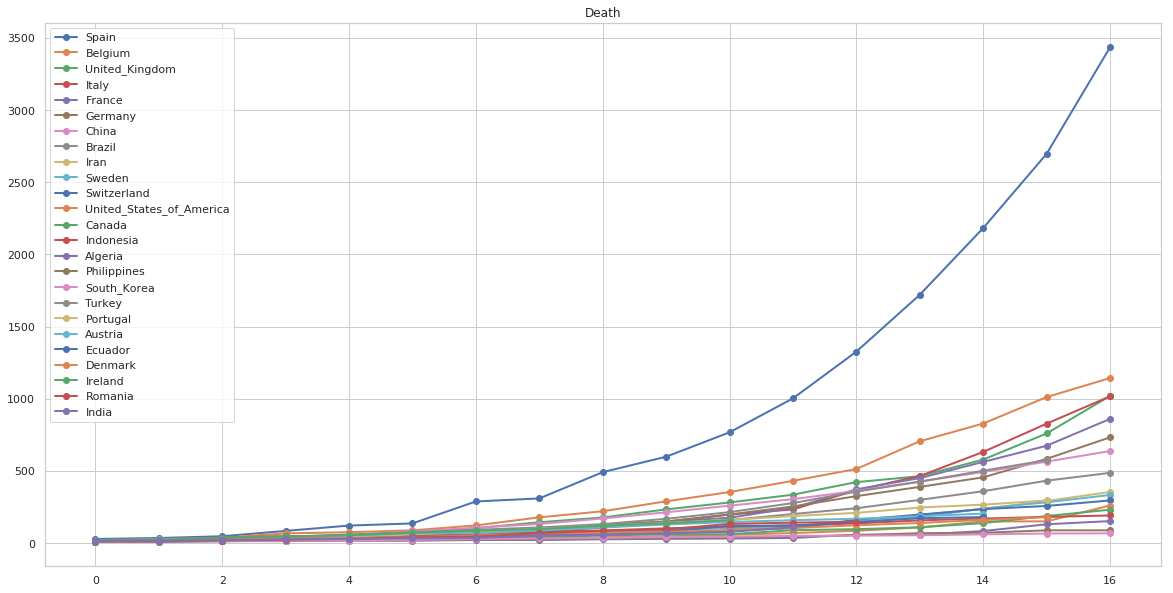

In [921]:
pt_world_data_deaths = world_data.pivot_table(values = 'deaths', index = 'country', columns = 'date', aggfunc = sum).cumsum(axis = 1)
pt_world_data_deaths = pt_world_data_deaths[pt_world_data_deaths[str_today] > 100]
pt_world_data_pop = world_data.pivot_table(values = 'population', index = 'country', columns = 'date', aggfunc = sum)
pt_world_data_pop = pt_world_data_pop[pt_world_data_pop[str_today] > 1000000]
pt_data = pt_world_data_deaths
pt_data = pt_data[~pt_data[str_today].isna()].sort_values(by=str_today, ascending = False)
df = pd.DataFrame()
for i in pt_data.iterrows():
    temp = i[1]
    temp = temp.loc[temp >= 10].reset_index(drop = True)
    df = df.append(temp)

# df = (df.div(pt_world_data_pop[str_today], axis = 0) * 100000)
df = df[~df[0].isna()]
df = df[df.loc[['Brazil']].dropna(axis = 1).columns]
df = df.sort_values(by = len(df.columns) -1, ascending = False)
    
plt.figure(figsize = (20,10))

plt.rc('font', **font)
# plt.yscale('log')
title = 'Death'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
    plt.legend()
    
plt.savefig('./img/' + title)



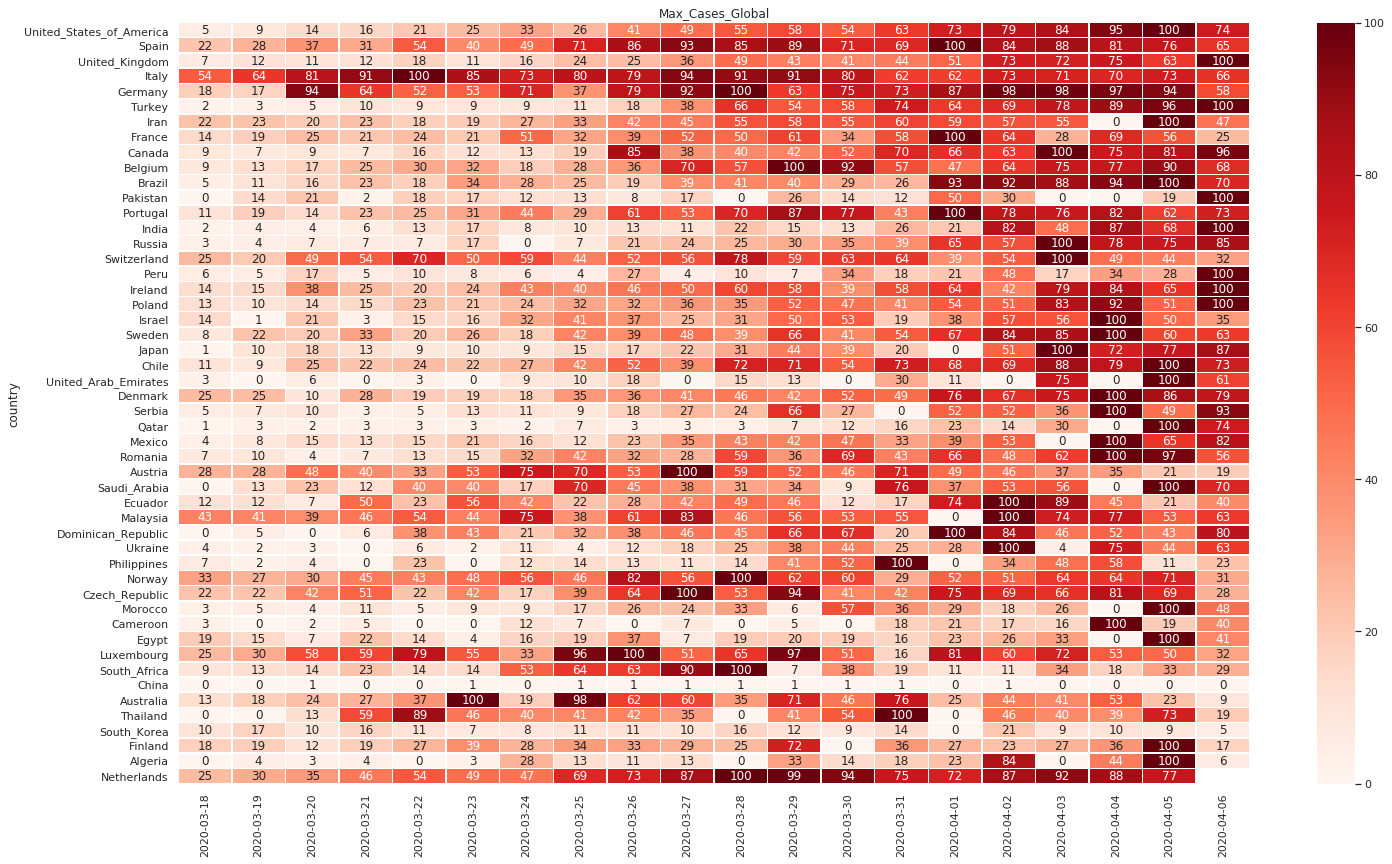

In [922]:
plt.figure(figsize = (24,14))
title = 'Max_Cases_Global'
max_cases = pt_world_daily.max(axis = 1)
df_aux = pt_world_daily[max_cases > 200]
df_aux = df_aux.sort_values(by=str_today, ascending = False)
df_aux.columns = df_aux.columns.date
df_result = df_aux.div(df_aux.max(axis = 1), axis = 0) * 100
df_result = df_result[df_result.columns[-20:]]
plt.title(title)
sns.heatmap(df_result, annot = True, linewidths = 0.5, cmap='Reds', fmt=',.0f')
plt.savefig('./img/' + title)
# df_aux

s:  0.8446004309005914
s_star:  2.3270478123838654


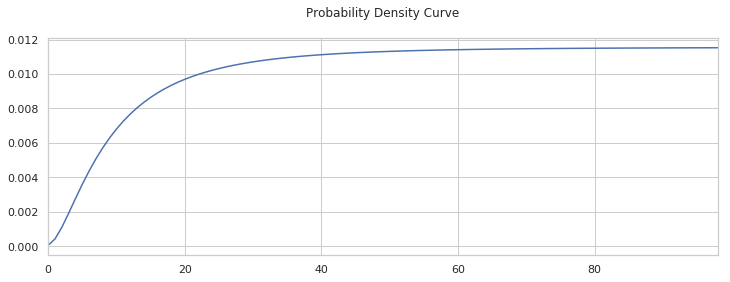

In [923]:
zmeanHDT = 13
zsdHDT = 12.7
zmedianHDT = 9.1
muHDT = np.log(zmedianHDT)
sigmaHDT = np.sqrt(2*(np.log(zmeanHDT/zmedianHDT)))
s = sigmaHDT
cCFRBaseline = 1.38
cCFREstimateRange = [1.23, 1.53]
cCFRIQRRange = [1.3, 1.4]

print('s: ',sigmaHDT)
print('s_star: ',np.exp(sigmaHDT))
# print('mu: ', muHDT)

# Hospitalisation to death distribution
def HDT(x):
    dist = stats.lognorm(s = sigmaHDT, scale = zmedianHDT)
    a = dist.cdf(x)
    return a
    

x = list(range(1,100))
p_curve = pd.Series([HDT(i) for i in x])
p_curve = p_curve / p_curve.sum()

plt.figure(figsize=(12,4))
plt.title('Probability Density Curve\n')
p_curve.plot()


In [924]:
n = 60
death_est = (2.0, 2.5, 3.0)

# print(world_data)
df = pd.DataFrame()
def loop_cases_analysis(i = 0):
    str_today = (dt.date.today() - dt.timedelta(hours=hh) - dt.timedelta(days=i)).strftime('%Y-%m-%d')
    print(str_today)
    world_data['rel_date'] = (dt.datetime.now() - dt.timedelta(days = i) - pd.to_datetime(world_data['date'])).dt.days
    world_data['known'] = HDT(world_data['rel_date'])
    world_data['known_cases'] = world_data['known'] * world_data['cases']
    wd_known_cases = world_data.pivot_table(values = 'known_cases', index = 'country', columns = 'date', aggfunc = 'sum').cumsum(axis = 1).fillna(0)
    wd_deaths = world_data.pivot_table(values = 'deaths', index = 'country', columns = 'date', aggfunc = 'sum').cumsum(axis = 1).fillna(0)
    wd_cases = world_data.pivot_table(values = 'cases', index = 'country', columns = 'date', aggfunc = 'sum').cumsum(axis = 1).fillna(0)
    wd_death_rate = (wd_deaths / wd_known_cases * 100).fillna(0)
    wd_death_rate = wd_death_rate[wd_death_rate[str_today] > 0]
    wd_reported = (death_est[1] / wd_death_rate * 100).replace(np.inf, np.nan)
    # wd_reported = wd_reported[wd_reported.columns[-4:]].sort_values(by = str_today, ascending = False)
    wd_reported = wd_reported.sort_values(by = str_today, ascending = False)
    # wd_reported.loc[['Germany', 'United_States_of_America', 'Italy','China']]
    # print(wd_known_cases)
    wd_curr = pd.DataFrame(wd_known_cases[str_today])
    wd_curr['cases'] = wd_cases[str_today]
    wd_curr['deaths'] = wd_deaths[str_today]
    wd_curr.columns = ['known', 'cases', 'deaths']
    wd_curr.loc['world'] = wd_curr.sum()
#     wd_curr = wd_curr[wd_curr['deaths'] > 5].sort_values(by='deaths')
    wd_copy = wd_curr.copy()
    wd_copy['not_known'] = (wd_curr['cases'] - wd_curr['known']) / wd_curr['cases']
    wd_copy['known'] = ( wd_curr['known']) / wd_curr['cases']
    wd_copy['total_cases'] = (wd_copy['deaths'] / wd_copy['known']) / (death_est[1] / 100)
    # wd_copy.sort_values(by = 'total_cases', ascending = False)[['total_cases']]
    wd_curr['quantile25'] = [conf_int(count = wd_curr.loc[i]['deaths'], nobs = wd_curr.loc[i]['known'], method = 'binom_test')[0] for i in wd_curr.index]
    wd_curr['quantile75'] = [conf_int(count = wd_curr.loc[i]['deaths'], nobs = wd_curr.loc[i]['known'], method = 'binom_test')[1] for i in wd_curr.index]
    wd_curr['average'] = wd_curr['deaths'] / wd_curr['known']
    wd_curr['death_est_avg'] = 2.5
    try:
        wd_curr.loc['Brazil']['death_est_avg'] = 1.1
        wd_curr.loc['Italy']['death_est_avg'] = 3.1
        wd_curr.loc['United_States_of_America']['death_est_avg'] = 2.0
        wd_curr.loc['Germany']['death_est_avg'] = 2.5
    except KeyError:
        pass
    wd_curr['quantile25_rep'] = (death_est[0] / wd_curr['quantile25']).replace(np.inf, np.nan)
    wd_curr['quantile75_rep'] = (death_est[2] / wd_curr['quantile75']).replace(np.inf, np.nan)
    wd_curr['average_rep'] = (wd_curr['death_est_avg'] / wd_curr['average']).replace(np.inf, np.nan)
    wd_curr = wd_curr[wd_curr['deaths'] >= 1].sort_values(by='average_rep', ascending = False)
    result = wd_curr['average_rep']
    result.name = str_today
    return result

num_cores = multiprocessing.cpu_count()
b_results = Parallel(n_jobs = num_cores, verbose = 5)(delayed(loop_cases_analysis)(i = x) for x in range(0,n))    

# proportion.proportion_confint(count = br_curr.loc['Brasil']['deaths'], nobs = br_curr.loc['Brasil']['known'], method = 'binom_test')
# br_curr.loc[0]['deaths']
df = pd.DataFrame(b_results)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   48.0s
[Parallel(n_jobs=8)]: Done  58 out of  60 | elapsed:  2.3min remaining:    4.9s
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:  2.4min finished


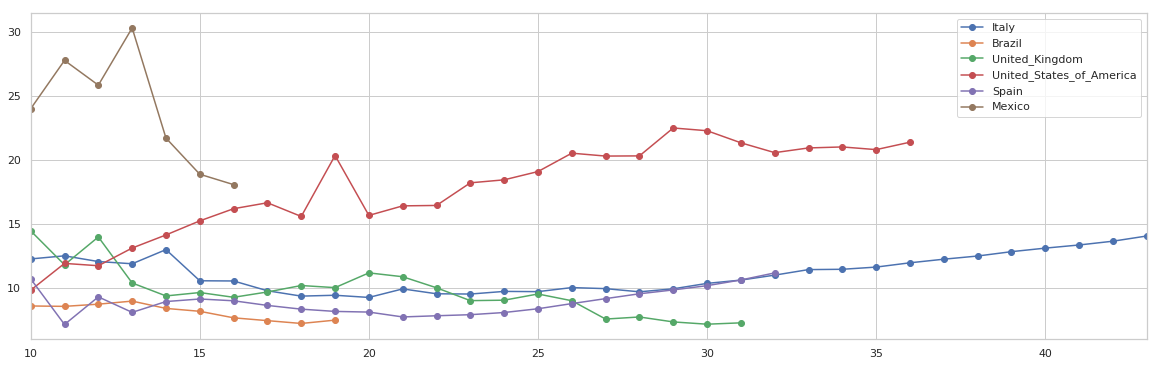

In [925]:
# df.loc[['Brazil']].T.sort_index()
# df.loc[['South_Korea']].T.sort_index()
df_2 = df[['Italy','Brazil', 'United_Kingdom', 'United_States_of_America', 'Spain', 'Mexico' ]]
df_adj = pd.DataFrame()
for a in df_2.columns:
    temp = df[a].dropna().sort_index().reset_index(drop = True)
    df_adj[temp.name] = temp

df_adj.loc[df_adj.index >= 10].plot(figsize = (20,6), marker = 'o')
# df_2['Brazil']

In [926]:
str_today = (dt.date.today() - dt.timedelta(hours=hh)).strftime('%Y-%m-%d')
print(str_today)
world_data['rel_date'] = (dt.datetime.now() - pd.to_datetime(world_data['date'])).dt.days
world_data['known'] = HDT(world_data['rel_date'])
world_data['known_cases'] = world_data['known'] * world_data['cases']
wd_known_cases = world_data.pivot_table(values = 'known_cases', index = 'country', columns = 'date', aggfunc = 'sum').cumsum(axis = 1).fillna(0)
wd_deaths = world_data.pivot_table(values = 'deaths', index = 'country', columns = 'date', aggfunc = 'sum').cumsum(axis = 1).fillna(0)
wd_cases = world_data.pivot_table(values = 'cases', index = 'country', columns = 'date', aggfunc = 'sum').cumsum(axis = 1).fillna(0)
wd_death_rate = (wd_deaths / wd_known_cases * 100).fillna(0)
wd_death_rate = wd_death_rate[wd_death_rate[str_today] > 0]
wd_reported = (death_est[1] / wd_death_rate * 100).replace(np.inf, np.nan)
# wd_reported = wd_reported[wd_reported.columns[-4:]].sort_values(by = str_today, ascending = False)
wd_reported = wd_reported.sort_values(by = str_today, ascending = False)
# wd_reported.loc[['Germany', 'United_States_of_America', 'Italy','China']]
# print(wd_known_cases)
wd_curr = pd.DataFrame(wd_known_cases[str_today])
wd_curr['cases'] = wd_cases[str_today]
wd_curr['deaths'] = wd_deaths[str_today]
wd_curr.columns = ['known', 'cases', 'deaths']
wd_curr.loc['world'] = wd_curr.sum()
wd_curr = wd_curr[wd_curr['deaths'] > 50].sort_values(by='deaths')
wd_copy = wd_curr.copy()
wd_copy['not_known'] = (wd_curr['cases'] - wd_curr['known']) / wd_curr['cases']
wd_copy['known'] = ( wd_curr['known']) / wd_curr['cases']
wd_copy['total_cases'] = (wd_copy['deaths'] / wd_copy['known']) / (death_est[1] / 100)
# wd_copy.sort_values(by = 'total_cases', ascending = False)[['total_cases']]
wd_curr['quantile25'] = [conf_int(count = wd_curr.loc[i]['deaths'], nobs = wd_curr.loc[i]['known'], method = 'binom_test')[0] for i in wd_curr.index]
wd_curr['quantile75'] = [conf_int(count = wd_curr.loc[i]['deaths'], nobs = wd_curr.loc[i]['known'], method = 'binom_test')[1] for i in wd_curr.index]
wd_curr['average'] = wd_curr['deaths'] / wd_curr['known']
wd_curr['death_est_avg'] = 2.5
try:
    wd_curr.loc['Brazil']['death_est_avg'] = 1.1
    wd_curr.loc['Italy']['death_est_avg'] = 3.1
    wd_curr.loc['United_States_of_America']['death_est_avg'] = 2.0
    wd_curr.loc['Germany']['death_est_avg'] = 2.5
except KeyError:
    pass
wd_curr['quantile25_rep'] = (death_est[0] / wd_curr['quantile25']).replace(np.inf, np.nan)
wd_curr['quantile75_rep'] = (death_est[2] / wd_curr['quantile75']).replace(np.inf, np.nan)
wd_curr['average_rep'] = (wd_curr['death_est_avg'] / wd_curr['average']).replace(np.inf, np.nan)
wd_curr = wd_curr[wd_curr['deaths'] >= 1].sort_values(by='average_rep', ascending = False)

2020-04-06


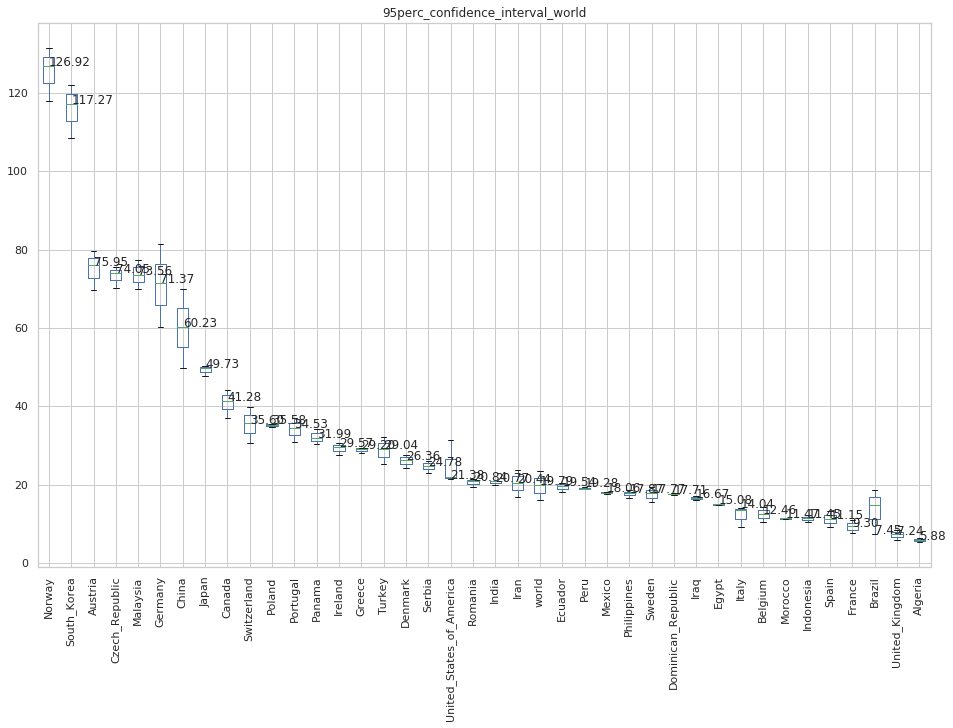

In [927]:
wd_curr[['quantile25_rep', 'quantile75_rep', 'average_rep']].T.plot(kind='box', figsize=(16,10), rot = 90)
df = wd_curr


title = '95perc_confidence_interval_world'
plt.title(title)
s = 1
for i in df.iterrows():
#     print(i[0])
    plt.annotate("{:.2f}".format(i[1]['average_rep']),(s,i[1]['average_rep']))
#     plt.annotate("{:.2f}".format(i[1]['quantile25_rep']),(s,i[1]['quantile25_rep']))
#     plt.annotate("{:.2f}".format(i[1]['quantile75_rep']),(s,i[1]['quantile75_rep']))
    s = s + 1
    
plt.savefig('./img/' + title)

In [928]:
wd_curr

known       cases    deaths  quantile25  \
country                                                                 
Norway                     2944.524    5640.000    58.000       0.015   
South_Korea                8725.049   10284.000   186.000       0.018   
Austria                    6197.197   11983.000   204.000       0.029   
Czech_Republic             1984.658    4587.000    67.000       0.027   
Malaysia                   1794.774    3662.000    61.000       0.026   
Germany                   40939.469   95391.000  1434.000       0.033   
China                     80347.126   82642.000  3335.000       0.040   
Japan                      1451.971    3654.000    73.000       0.040   
Canada                     4623.470   15496.000   280.000       0.054   
Switzerland               10180.817   21065.000   715.000       0.065   
Poland                     1337.688    4102.000    94.000       0.057   
Portugal                   4074.941   11278.000   295.000       0.065   
Panama                      690.893    1988.000    54.000       0.058   
Ireland                    1868.998    5111.000   158.000       0.073   
Greece                      852.761    1735.000    73.000       0.069   
Turkey                     6666.904   27069.000   574.000       0.080   
Denmark                    1887.344    4369.000   179.000       0.082   
Serbia                      505.513    1908.000    51.000       0.077   
United_States_of_America 103125.531  337635.000  9647.000       0.092   
Romania                    1233.624    3864.000   148.000       0.103   
India                       905.612    4067.000   109.000       0.100   
Iran                      29462.360   58226.000  3603.000       0.119   
world                    532781.975 1227092.000 67318.000       0.125   
Ecuador                    1406.763    3646.000   180.000       0.111   
Peru                        639.993    2281.000    83.000       0.105   
Mexico                      678.980    2143.000    94.000       0.114   
Philippines                1086.625    3246.000   152.000       0.120   
Sweden                     2850.058    6830.000   401.000       0.128   
Dominican_Republic          581.025    1745.000    82.000       0.114   
Iraq                        406.705     961.000    61.000       0.118   
Egypt                       428.351    1070.000    71.000       0.133   
Italy                     71943.145  128948.000 15889.000       0.218   
Belgium                    7211.629   19691.000  1447.000       0.192   
Morocco                     321.187    1021.000    70.000       0.176   
Indonesia                   906.835    2273.000   198.000       0.193   
Spain                     55375.655  130759.000 12418.000       0.221   
France                    30035.183   70478.000  8078.000       0.264   
Brazil                     3292.305   11130.000   486.000       0.136   
United_Kingdom            14288.350   47806.000  4934.000       0.338   
Algeria                     357.751    1320.000   152.000       0.375   

                          quantile75  average  death_est_avg  quantile25_rep  \
country                                                                        
Norway                         0.025    0.020          2.500         131.510   
South_Korea                    0.025    0.021          2.500         108.489   
Austria                        0.038    0.033          2.500          69.686   
Czech_Republic                 0.043    0.034          2.500          75.416   
Malaysia                       0.043    0.034          2.500          77.437   
Germany                        0.037    0.035          2.500          60.100   
China                          0.043    0.042          2.500          49.822   
Japan                          0.063    0.050          2.500          50.175   
Canada                         0.068    0.061          2.500          37.079   
Switzerland                    0.075    0.070          2.500          30.576   
Pol

In [970]:
br_state_file = './'
kaggle.api.authenticate()
kaggle.api.dataset_download_files('unanimad/corona-virus-brazil/metadata', path=br_state_file, unzip=True)

br_state = pd.read_csv('brazil_covid19.csv')
# br_state['total'] = br_state['cases'] + br_state['refuses']
# br_state['total_susp'] = br_state['cases'] +  br_state['refuses'] + br_state['suspects']
# br_state['positive_rate'] = br_state['cases'] / br_state['total'] * 100
br_state_copy = br_state.copy()
br_state = br_state[br_state['date'] == str_today]
br_state = br_state.set_index('state', drop=True)
br_state['death_rate'] = br_state['deaths'] / br_state['cases'] * 100
br_state_data = pd.read_csv('br_states_data.csv')
br_state_data = br_state_data.drop(['Bandeira', 'Sede de governo','Alfabetização (2016)', 'Mortalidade infantil (2016)', 'Expectativa de vida (2016)'], axis = 1)
br_state_data.columns = ['state', 'state_2digits', 'area', 'population', 'density', 'gdp', 'share','gdp_per_capita', 'hdi']
br_state_data = br_state_data.set_index('state', drop=True)
br_state_data = br_state.merge(br_state_data, on='state')
br_state_data['area'] = br_state_data['area'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['population'] = br_state_data['population'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['gdp'] = br_state_data['gdp'].str.replace(',','').str.replace('\xa0','').astype(float)
br_state_data['gdp_per_capita'] = br_state_data['gdp_per_capita'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['hdi'] = br_state_data['hdi'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['density'] = br_state_data['density'].str.replace(',','.').str.replace('\xa0','').astype(float)
# br_state_data['tests_per_1000'] = br_state_data['total'] / br_state_data['population'] * 1000
# br_state_data = br_state_data.set_index('state_2digits', drop = True)
# br_state
print(br_state_copy['date'].max())

2020-04-06


In [971]:
br_date = br_state_copy.groupby('date').sum()
br_date['death_rate'] = (br_date['deaths'] / br_date['cases']).fillna(0)
br_date['new_cases'] = br_date['cases'].diff().fillna(0)
br_date = br_date[br_date.index > '2020-02-20']

In [972]:
plt.figure(figsize = (20,50))

plt.subplot('511')
xs = br_date.index.values
ys = br_date['cases']
plt.gca().set_title('Total number of cases')
plt.plot(xs, ys, 'bo-')
plt.xticks(xs, xs, rotation='vertical')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('512')
plt.gca().set_title('Total number of deaths')
ys = br_date['deaths']
plt.plot(xs, ys, 'r^-')
plt.xticks(xs, xs, rotation='vertical')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('513')
plt.gca().set_title('Cumulative Death Rate')
ys = br_date['deaths'] / br_date['cases'] * 100
plt.plot(xs, ys, 'gs-')
plt.xticks(xs, xs, rotation='vertical')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('514')
plt.gca().set_title('New_cases')
ys = br_date['new_cases']
# plt.plot(x = xs, y = ys)
br_date['new_cases'].plot(kind = 'bar')
# for x,y in zip(xs,ys):
#     label = "{:.0f}".format(y)
#     plt.annotate(label, # this is the text
#                  (x,y), # this is the point to label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,10), # distance from text to points (x,y)
#                  ha='center') # horizontal alignment can be left, right or center

# plt.savefig('./img/br_overview')

plt.subplot('515')
plt.gca().set_title('New Cases as % of Total')
ys = br_date['new_cases'] / br_date['cases'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.savefig('./img/ny_overview')
plt.show()

plt.savefig('./img/br_overview')
plt.show()

<Figure size 432x288 with 0 Axes>

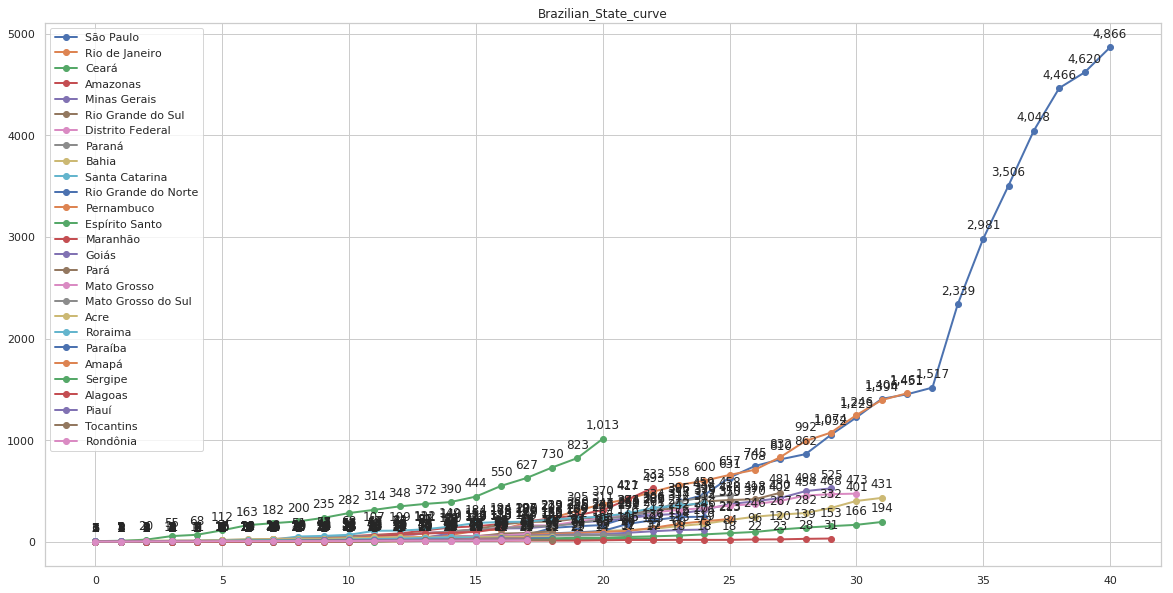

In [940]:
pt_br_state = br_state_copy.pivot_table(values = 'cases', index = 'state', columns = 'date', aggfunc='sum')
pt_br_state = pt_br_state.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))

# plt.rc('font', **font)
title = 'Brazilian_State_curve'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    xs = temp.index
    ys = temp
    plt.plot(xs, ys, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        label = "{:,.0f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)

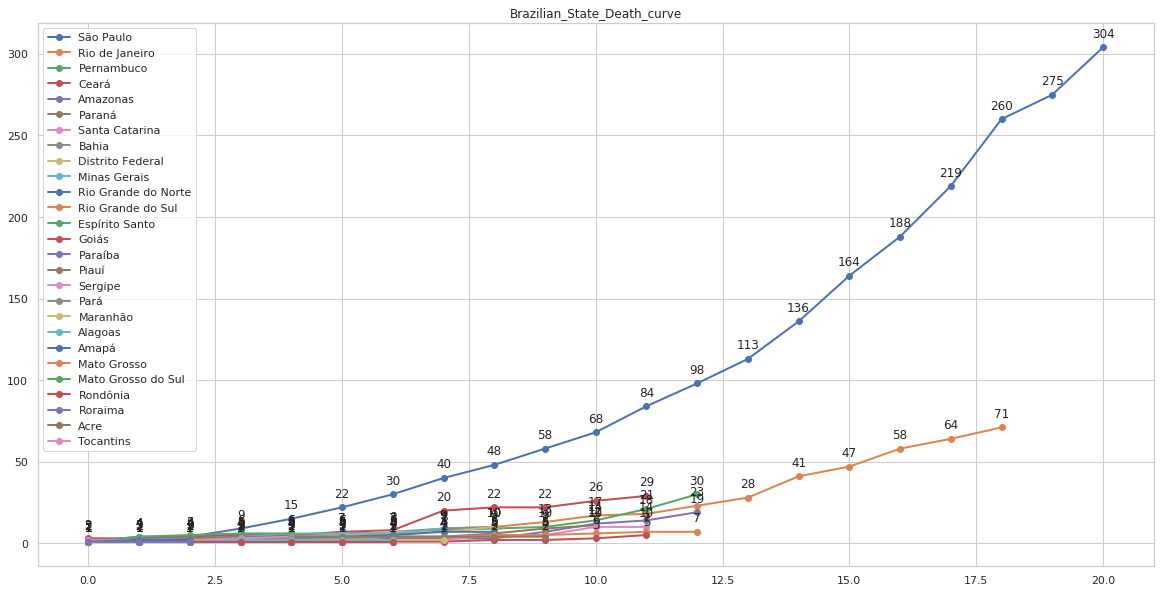

In [974]:
pt_br_state_death = br_state_copy.pivot_table(values = 'deaths', index = 'state', columns = 'date', aggfunc='sum')
pt_br_state_death = pt_br_state_death.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state_death.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))

# plt.rc('font', **font)
title = 'Brazilian_State_Death_curve'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    xs = temp.index
    ys = temp
    plt.plot(xs, ys, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        label = "{:,.0f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)

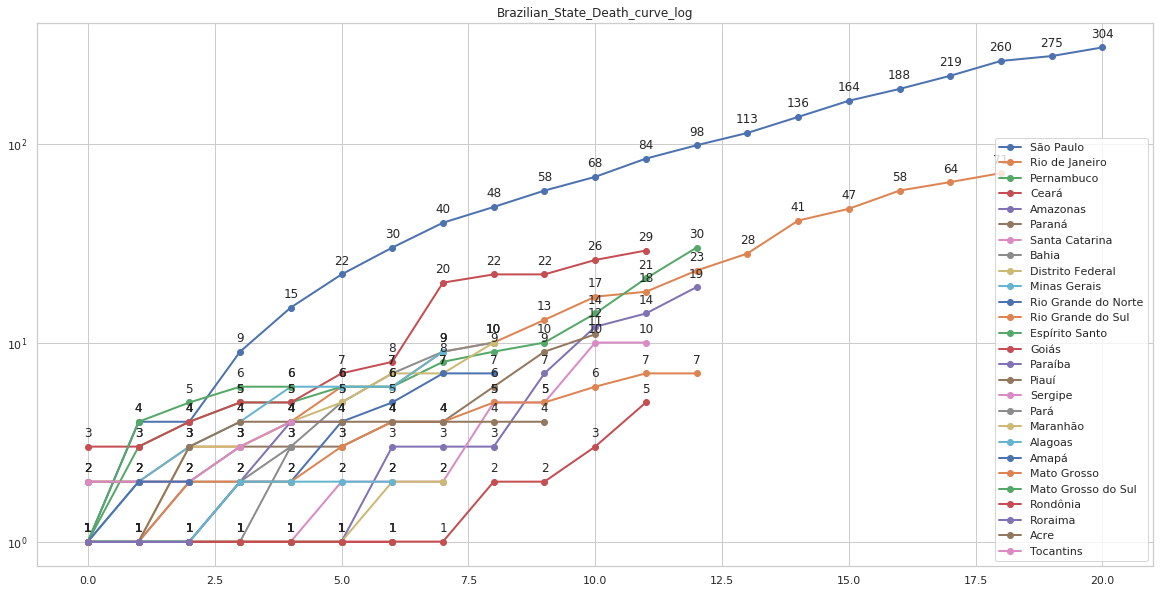

In [975]:
pt_br_state_death = br_state_copy.pivot_table(values = 'deaths', index = 'state', columns = 'date', aggfunc='sum')
pt_br_state_death = pt_br_state_death.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state_death.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))
plt.yscale('log')
# plt.rc('font', **font)
title = 'Brazilian_State_Death_curve_log'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    xs = temp.index
    ys = temp
    plt.plot(xs, ys, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        label = "{:,.0f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)

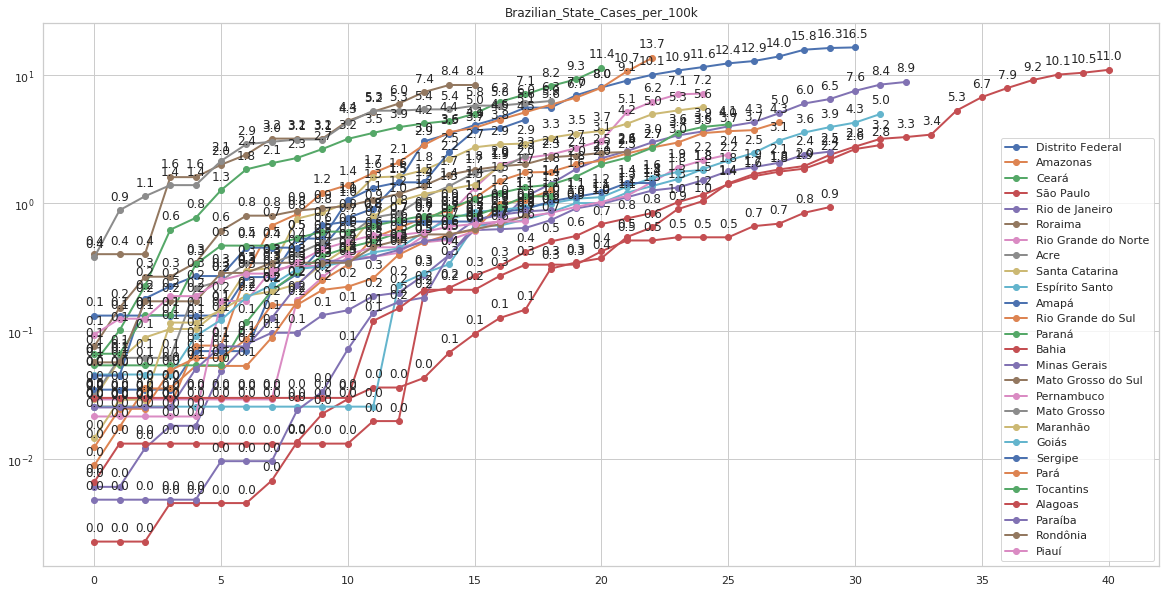

In [985]:
pt_br_state_adj =  pt_br_state.div(br_state_data['population'], axis = 0) * 100000
pt_br_state_adj = pt_br_state_adj.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state_adj.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))

plt.rc('font', **font)
title = 'Brazilian_State_Cases_per_100k'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    xs = temp.index
    ys = temp
    plt.plot(xs, ys, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        label = "{:,.1f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)

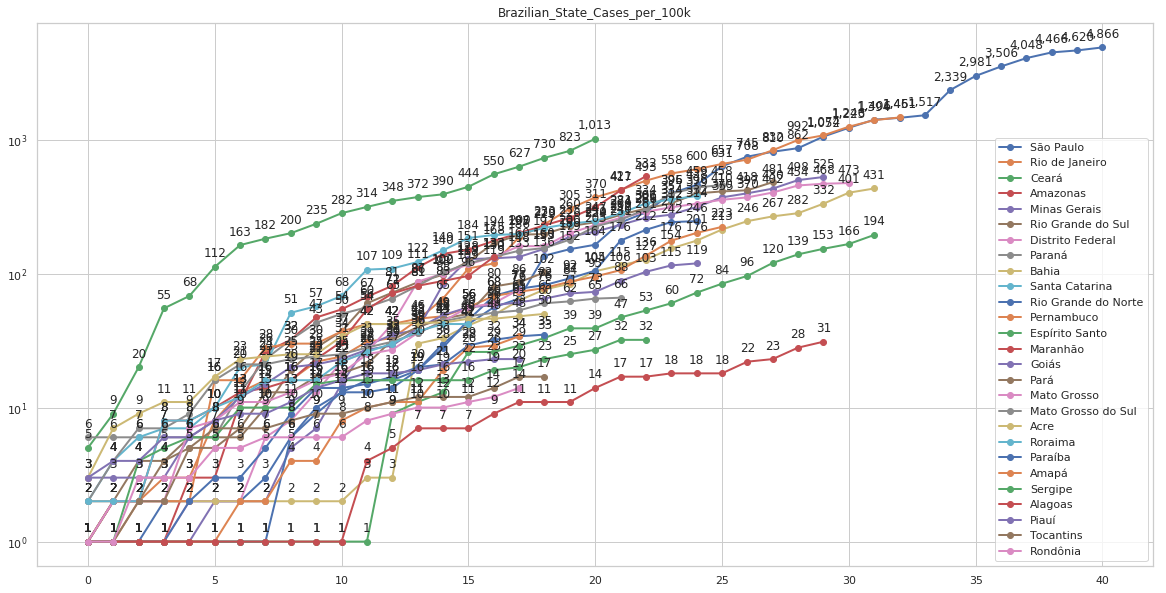

In [987]:
pt_br_state_adj =  pt_br_state
pt_br_state_adj = pt_br_state_adj.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state_adj.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))
plt.yscale('log')

plt.rc('font', **font)
title = 'Brazilian_State_Cases_Log'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    xs = temp.index
    ys = temp
    plt.plot(xs, ys, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        label = "{:,.0f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)

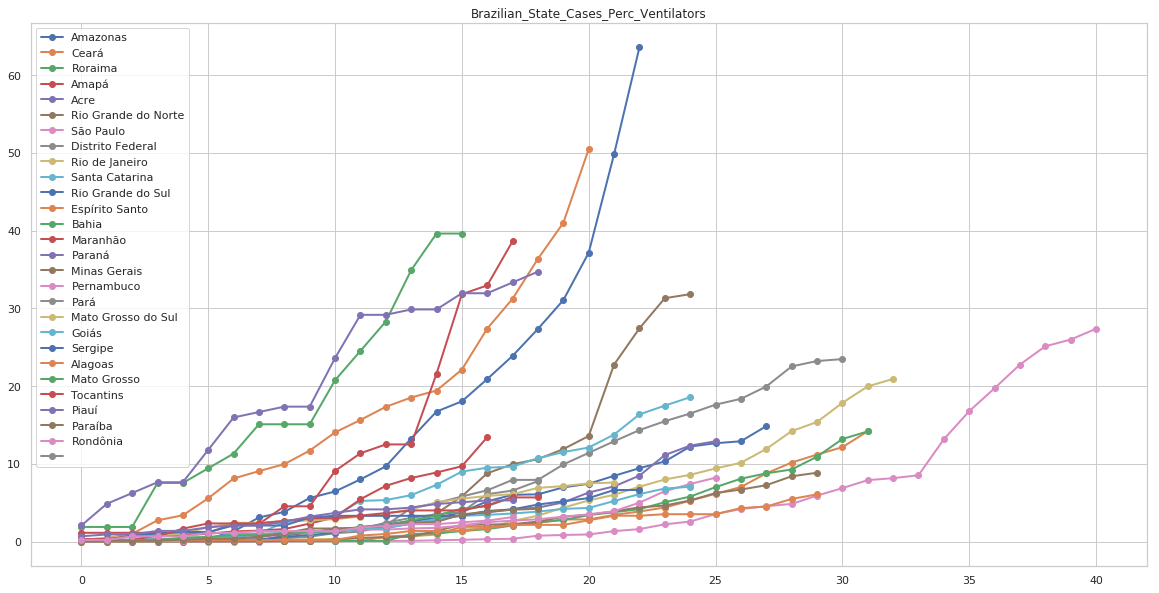

In [945]:
pt_br_state_adj =  pt_br_state.div(resp['equipments'], axis = 0) * 100
pt_br_state_adj = pt_br_state_adj.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state_adj.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))

plt.rc('font', **font)
title = 'Brazilian_State_Cases_Perc_Ventilators'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
    plt.legend()
    
plt.savefig('./img/' + title)

In [946]:
pt_br_state_death  = br_state_copy.pivot_table(values = 'deaths', index = 'state', columns = 'date', aggfunc='sum') / pt_br_state * 100
# pt_br_state_death.loc['Ceará']['2020-03-28'] = 4
# pt_br_state_death.loc['Rio Grande do Sul']['2020-03-28'] = 2
pt_br_state_death = pt_br_state_death.sort_values(by=str_today, ascending = False)


In [983]:
pt_br_state = br_state_copy.pivot_table(values = 'cases', index = 'state', columns = 'date', aggfunc='sum')
pt_br_state = pt_br_state.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))
plt.yscale('log')
plt.rc('font', **font)
title = 'Brazilian_State_curve_Log'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        xs = temp.index
        ys = temp
        label = "{:,.0f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)

In [948]:
plt.figure(figsize = (24,12))
title = 'Max_Cases_Brasil_100'
pt_br_state_daily = pt_br_state.diff(axis = 1)
df_aux = pt_br_state_daily[pt_br_state_daily.columns[-20:]]
df_aux.loc['Brasil'] = df_aux.sum()
# df_aux.columns = df_aux.columns.date
df_result = df_aux.div(df_aux.max(axis = 1), axis = 0) * 100
plt.title(title)
sns.heatmap(df_result.sort_values(by=str_today, ascending = False), annot = True, linewidths = 0.5, cmap='Reds', fmt=',.0f')
plt.savefig('./img/' +title)
# df_result
# pt_br_state

In [949]:
plt.figure(figsize = (24,12))
title = 'New_Cases_Brasil'
pt_br_state_daily = pt_br_state.diff(axis = 1)
df_aux = pt_br_state_daily[pt_br_state_daily.columns[-20:]]
df_aux.loc['Brasil'] = df_aux.sum()
# df_aux.columns = df_aux.columns.date
df_result = df_aux
plt.title(title)
sns.heatmap(df_result.sort_values(by=str_today, ascending = False), annot = True, linewidths = 0.5, cmap='Reds', fmt=',.0f')
plt.savefig('./img/' + title)
# df_result
# pt_br_state

In [950]:
br_cases = pd.DataFrame(br_state_copy.pivot_table(values = 'cases', index = 'state', columns = 'date', aggfunc = 'sum').fillna(0).diff(axis = 1).fillna(0).unstack())
br_cases.columns = ['cases']
br_cases = br_cases.reset_index()

In [951]:
br_cases['rel_date'] = (dt.datetime.now() - pd.to_datetime(br_cases['date'])).dt.days
br_cases['known'] = HDT(br_cases['rel_date'])
br_cases['known_cases'] = br_cases['known'] * br_cases['cases']

br_total_cases = br_cases.pivot_table(values = 'cases', index = 'state', columns = 'date', aggfunc = 'sum').cumsum(axis = 1)
br_total_cases.loc['Brasil'] = br_total_cases.sum()
total_cases = br_total_cases.loc['Brasil']
br_total_cases

br_known_cases = br_cases.pivot_table(values = 'known_cases', index = 'state', columns = 'date', aggfunc = 'sum').cumsum(axis = 1)
df = br_known_cases.sort_values(by=str_today, ascending = False)
br_known_cases.loc['Brasil'] = br_known_cases.sum()
br_known_cases

date                 2020-01-30  2020-01-31  2020-02-01  2020-02-02  \
state                                                                 
Acre                      0.000       0.000       0.000       0.000   
Alagoas                   0.000       0.000       0.000       0.000   
Amapá                     0.000       0.000       0.000       0.000   
Amazonas                  0.000       0.000       0.000       0.000   
Bahia                     0.000       0.000       0.000       0.000   
Ceará                     0.000       0.000       0.000       0.000   
Distrito Federal          0.000       0.000       0.000       0.000   
Espírito Santo            0.000       0.000       0.000       0.000   
Goiás                     0.000       0.000       0.000       0.000   
Maranhão                  0.000       0.000       0.000       0.000   
Mato Grosso               0.000       0.000       0.000       0.000   
Mato Grosso do Sul        0.000       0.000       0.000       0.000   
Minas Gerais              0.000       0.000       0.000       0.000   
Paraná                    0.000       0.000       0.000       0.000   
Paraíba                   0.000       0.000       0.000       0.000   
Pará                      0.000       0.000       0.000       0.000   
Pernambuco                0.000       0.000       0.000       0.000   
Piauí                     0.000       0.000       0.000       0.000   
Rio Grande do Norte       0.000       0.000       0.000       0.000   
Rio Grande do Sul         0.000       0.000       0.000       0.000   
Rio de Janeiro            0.000       0.000       0.000       0.000   
Rondônia                  0.000       0.000       0.000       0.000   
Roraima                   0.000       0.000       0.000       0.000   
Santa Catarina            0.000       0.000       0.000       0.000   
Sergipe                   0.000       0.000       0.000       0.000   
São Paulo                 0.000       0.000       0.000       0.000   
Tocantins                 0.000       0.000       0.000       0.000   
Brasil                    0.000       0.000       0.000       0.000   

date                 2020-02-03  2020-02-04  2020-02-05  2020-02-06  \
state                                                                 
Acre                      0.000       0.000       0.000       0.000   
Alagoas                   0.000       0.000       0.000       0.000   
Amapá                     0.000       0.000       0.000       0.000   
Amazonas                  0.000       0.000       0.000       0.000   
Bahia                     0.000       0.000       0.000       0.000   
Ceará                     0.000       0.000       0.000       0.000   
Distrito Federal          0.000       0.000       0.000       0.000   
Espírito Santo            0.000       0.000       0.000       0.000   
Goiás                     0.000       0.000       0.000       0.000   
Maranhão                  0.000       0.000       0.000       0.000   
Mato Grosso               0.000       0.000       0.000       0.000   
Mato Grosso do Sul        0.000       0.000       0.000       0.000   
Minas Gerais              0.000       0.000       0.000       0.000   
Paraná                    0.000       0.000       0.000       0.000   
Paraíba                   0.000       0.000       0.000       0.000   
Pará                      0.000       0.000       0.000       0.000   
Pernambuco                0.000       0.000       0.000       0.000   
Piauí                     0.000       0.000       0.000       0.000   
Rio Grande do Norte       0.000       0.000       0.000       0.000   
Rio Grande do Sul         0.000       0.000       0.000       0.000   
Rio de Janeiro            0.000       0.000       0.000       0.000   
Rondônia                  0.000       0.000       0.000       0.000   
Roraima                   0.000       0.000       0.000       0.000   
Santa Catarina            0.000       0.000       0.000       0.000   
Sergipe                

In [952]:
br_deaths = br_state_copy.pivot_table(values = 'deaths', index = 'state', columns = 'date', aggfunc = 'sum').fillna(0)
# br_deaths.loc['Ceará']['2020-03-28'] = 4
# br_deaths.loc['Rio Grande do Sul']['2020-03-28'] = 2
br_deaths.loc['Brasil'] = br_deaths.sum()
br_deaths

date                 2020-01-30  2020-01-31  2020-02-01  2020-02-02  \
state                                                                 
Acre                          0           0           0           0   
Alagoas                       0           0           0           0   
Amapá                         0           0           0           0   
Amazonas                      0           0           0           0   
Bahia                         0           0           0           0   
Ceará                         0           0           0           0   
Distrito Federal              0           0           0           0   
Espírito Santo                0           0           0           0   
Goiás                         0           0           0           0   
Maranhão                      0           0           0           0   
Mato Grosso                   0           0           0           0   
Mato Grosso do Sul            0           0           0           0   
Minas Gerais                  0           0           0           0   
Paraná                        0           0           0           0   
Paraíba                       0           0           0           0   
Pará                          0           0           0           0   
Pernambuco                    0           0           0           0   
Piauí                         0           0           0           0   
Rio Grande do Norte           0           0           0           0   
Rio Grande do Sul             0           0           0           0   
Rio de Janeiro                0           0           0           0   
Rondônia                      0           0           0           0   
Roraima                       0           0           0           0   
Santa Catarina                0           0           0           0   
Sergipe                       0           0           0           0   
São Paulo                     0           0           0           0   
Tocantins                     0           0           0           0   
Brasil                        0           0           0           0   

date                 2020-02-03  2020-02-04  2020-02-05  2020-02-06  \
state                                                                 
Acre                          0           0           0           0   
Alagoas                       0           0           0           0   
Amapá                         0           0           0           0   
Amazonas                      0           0           0           0   
Bahia                         0           0           0           0   
Ceará                         0           0           0           0   
Distrito Federal              0           0           0           0   
Espírito Santo                0           0           0           0   
Goiás                         0           0           0           0   
Maranhão                      0           0           0           0   
Mato Grosso                   0           0           0           0   
Mato Grosso do Sul            0           0           0           0   
Minas Gerais                  0           0           0           0   
Paraná                        0           0           0           0   
Paraíba                       0           0           0           0   
Pará                          0           0           0           0   
Pernambuco                    0           0           0           0   
Piauí                         0           0           0           0   
Rio Grande do Norte           0           0           0           0   
Rio Grande do Sul             0           0           0           0   
Rio de Janeiro                0           0           0           0   
Rondônia                      0           0           0           0   
Roraima                       0           0           0           0   
Santa Catarina                0           0           0           0   
Sergipe                

In [953]:
a = 486 / (3292 / 0.088) 
b = (3823 / 0.086)
c = (6836 + 5717) / 2 / 0.097
print(a)
print(a * b)
print(a * b / 0.046)
print(c)

0.01299149453219927
577.5172511232304
12554.722850505008
64706.18556701031


In [954]:
a = 299 / (2074 / 0.09) 
b = (2418 / 0.08)
c = (6836 + 5717) / 2 / 0.097
print(a)
print(a * b)
print(a * b / 0.035)
print(c)

0.012974927675988427
392.1671890067502
11204.77682876429
64706.18556701031


In [955]:
br_death_rate = (br_deaths / br_known_cases * 100).fillna(0)

In [956]:
br_death_rate = br_death_rate[br_death_rate[str_today] > 0]
# br_death_rate

In [957]:
death_est = [1.2, 1.3, 1.4]

br_reported = (death_est[1] / br_death_rate * 100).replace(np.inf, np.nan)
# known_cases = br_known_cases.loc['Brasil']
br_reported = br_reported[br_reported.columns[-4:]].sort_values(by = str_today, ascending = False)
br_reported

date                 2020-04-03  2020-04-04  2020-04-05  2020-04-06
state                                                              
Mato Grosso do Sul       38.973      39.068      39.085      39.085
Rio Grande do Sul        46.328      38.717      33.193      33.193
Distrito Federal         55.528      40.015      40.026      28.018
Minas Gerais             40.065      40.325      40.391      26.927
Mato Grosso              19.750      20.318      20.342      20.342
Santa Catarina           36.332      36.834      18.430      18.430
Bahia                    33.706      24.414      19.033      17.130
Maranhão                 31.232      31.564      15.805      15.805
Roraima                     nan      15.315      15.344      15.344
Paraná                   40.478      27.727      18.513      15.147
Ceará                    16.147      16.368      13.871      12.436
Espírito Santo           18.215      14.704      12.266      12.266
Goiás                    28.070      28.425      18.973      11.384
Rio Grande do Norte      17.146      14.057      10.066      10.066
Rio de Janeiro           13.456      11.045      10.023       9.034
Brasil                   13.669      11.493      10.226       8.987
Pará                     24.371      25.791      25.826       8.609
Alagoas                   7.558       7.582       7.596       7.596
Amazonas                 19.679      11.681      10.056       7.410
São Paulo                 9.131       7.767       7.347       6.646
Rondônia                  6.557       6.604       6.610       6.610
Sergipe                   8.917       8.965       5.986       4.490
Amapá                       nan       7.547       3.776       3.776
Paraíba                  13.801       6.972       3.489       3.489
Piauí                     3.359       3.370       3.372       3.372
Pernambuco                7.840       5.735       3.830       2.681

In [958]:
# tps = pd.DataFrame([known_cases, total_cases - known_cases], index = ['wo_outcome', 'w_outcome']).T
# tps = tps[tps['w_outcome'] > 0]
# tps = tps.div(tps.sum(1), axis=0)
# tps.plot(kind='bar', stacked=True, figsize = (20,4))

# title = 'Share_cases_w_Outcome'
# plt.title(title)
# plt.savefig('./img/' + title)

In [959]:
br_curr = br_known_cases[[str_today]]
br_curr['cases'] = br_total_cases[str_today]
br_curr['deaths'] = br_deaths[str_today]
br_curr.columns = ['known', 'cases', 'deaths']

br_copy = br_curr[br_curr['deaths'] > 0]
br_copy['not_known'] = (br_copy['cases'] - br_copy['known']) / br_copy['cases']
br_copy['known'] = ( br_copy['known']) / br_copy['cases']
br_copy['total_cases'] = (br_copy['deaths'] / br_copy['known']) / (death_est[1] / 100)
br_copy.drop(['cases', 'deaths'], axis = 1).sort_values(by = 'total_cases', ascending = False)
# br_known_cases[[str_today]]

known  not_known  total_cases
state                                             
Brasil               0.317      0.683   134144.301
São Paulo            0.319      0.681    73219.328
Rio de Janeiro       0.338      0.662    16171.424
Pernambuco           0.277      0.723     8317.250
Ceará                0.274      0.726     8145.780
Amazonas             0.204      0.796     7179.713
Paraná               0.280      0.720     3023.771
Bahia                0.306      0.694     2516.053
Rio Grande do Norte  0.220      0.780     2443.915
Santa Catarina       0.374      0.626     2056.389
Minas Gerais         0.355      0.645     1949.690
Distrito Federal     0.456      0.544     1688.176
Espírito Santo       0.292      0.708     1581.584
Rio Grande do Sul    0.372      0.628     1449.099
Pará                 0.195      0.805     1184.861
Goiás                0.368      0.632     1045.324
Paraíba              0.307      0.693     1003.215
Amapá                0.171      0.829      900.345
Maranhão             0.183      0.817      841.501
Sergipe              0.432      0.568      712.769
Piauí                0.451      0.549      682.101
Alagoas              0.377      0.623      408.107
Mato Grosso          0.206      0.794      373.620
Roraima              0.281      0.719      273.723
Rondônia             0.363      0.637      211.799
Mato Grosso do Sul   0.456      0.544      168.862

In [960]:
br_curr['quantile25'] = [conf_int(count = br_curr.loc[i]['deaths'], nobs = br_curr.loc[i]['known'], method = 'binom_test')[0] for i in br_curr.index]
br_curr['quantile75'] = [conf_int(count = br_curr.loc[i]['deaths'], nobs = br_curr.loc[i]['known'], method = 'binom_test')[1] for i in br_curr.index]
br_curr['average'] = br_curr['deaths'] / br_curr['known']
br_curr['quantile25_rep'] = (death_est[0] / br_curr['quantile25']).replace(np.inf, np.nan)
br_curr['quantile75_rep'] = (death_est[2] / br_curr['quantile75']).replace(np.inf, np.nan)
br_curr['average_rep'] = (death_est[1] / br_curr['average']).replace(np.inf, np.nan)
br_curr = br_curr[br_curr['deaths'] >= 2].sort_values(by='average_rep')

# proportion.proportion_confint(count = br_curr.loc['Brasil']['deaths'], nobs = br_curr.loc['Brasil']['known'], method = 'binom_test')
# br_curr.loc[0]['deaths']
    
br_curr[['quantile25_rep', 'quantile75_rep', 'average_rep']].T.plot(kind='box', figsize=(16,10))
df = br_curr


title = '95perc_conf_interval'
plt.title(title)
s = 1
for i in df.iterrows():
#     print(i[0])
    plt.annotate("{:.2f}".format(i[1]['average_rep']),(s,i[1]['average_rep']))
#     plt.annotate("{:.2f}".format(i[1]['quantile25_rep']),(s,i[1]['quantile25_rep']))
#     plt.annotate("{:.2f}".format(i[1]['quantile75_rep']),(s,i[1]['quantile75_rep']))
    s = s + 1
    
plt.savefig('./img/' + title)
# df

In [961]:
df['est_cases'] = df['cases'] / df['average_rep'] * 100
# df['est_cases'] = df['est_cases'] / 71000 * 64000
df['est_cases'].sort_values(ascending = False)

state
Brasil                134144.301
São Paulo              73219.328
Rio de Janeiro         16171.424
Pernambuco              8317.250
Ceará                   8145.780
Amazonas                7179.713
Paraná                  3023.771
Bahia                   2516.053
Rio Grande do Norte     2443.915
Santa Catarina          2056.389
Minas Gerais            1949.690
Distrito Federal        1688.176
Espírito Santo          1581.584
Rio Grande do Sul       1449.099
Pará                    1184.861
Goiás                   1045.324
Paraíba                 1003.215
Amapá                    900.345
Maranhão                 841.501
Sergipe                  712.769
Piauí                    682.101
Alagoas                  408.107
Name: est_cases, dtype: float64

In [962]:
df_tests = pd.read_csv('20200401_tests.csv')
df_tests['total_tests'] = df_tests['fast tests'] + df_tests['RT-PCR']
df_tests = df_tests.merge(br_state_data[['population']], on='state')
df_tests

state  fast tests  RT-PCR  total_tests   population
0                  Acre        2012     120         2132   795145.000
1               Alagoas        6986     888         7874  3327551.000
2                 Amapá        1854     840         2694   756500.000
3              Amazonas        8586    1872        10458  3893763.000
4                 Bahia       31634    2640        34274 15150143.000
5                 Ceará       18057    2280        20337  8867448.000
6      Distrito Federal        7492    4272        11764  2867869.000
7        Espírito Santo        9010    2232        11242  3894899.000
8                 Goiás       13717    2064        15781  6551322.000
9              Maranhão       14381     600        14981  6861924.000
10          Mato Grosso        7245     624         7869  3236578.000
11   Mato Grosso do Sul        7047    1776         8823  2630098.000
12         Minas Gerais       50920    4584        55504 20777672.000
13                 Pará       14806    3384        18190  8101180.000
14              Paraíba        8870    1032         9902  3950359.000
15               Paraná       26199    2832        29031 11112062.000
16           Pernambuco       20049    2208        22257  9297861.000
17                Piauí        7260     672         7932  3198185.000
18       Rio de Janeiro       37636    5040        42676 16497395.000
19  Rio Grande do Norte        7729     768         8497  3419550.000
20    Rio Grande do Sul       28941    3384        32325 11228091.000
21             Rondônia        3921     984         4905  1755015.000
22              Roraima        1459     864         2323   500826.000
23       Santa Catarina       16679    2712        19391  6734568.000
24            São Paulo      106787    4592       111379 44169350.000
25              Sergipe        5258     936         6194  2227294.000
26            Tocantins        4268     624         4892  1502759.000

In [963]:
df_cases = br_total_cases[[str_today]]
df_cases.columns = ['cases']
df_cases = df_cases.sort_values(by='cases', ascending = False)
df_tests_cases = df_cases.merge(df_tests, left_index = True, right_on = 'state').set_index('state')

In [964]:
df_tests_cases['multiple'] = df_tests_cases['total_tests'] / df_tests_cases['cases']
df_tests_cases['est_tests'] = df_tests_cases['cases'] / 0.20
df_tests_cases['multiple'].plot(kind='bar', figsize=(15,4))
ys = df_tests_cases['multiple']
xs = range(0,len(ys))
for x,y in zip(xs,ys):
    label = "{:,.0f}x".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.savefig('img/multiple_tests')

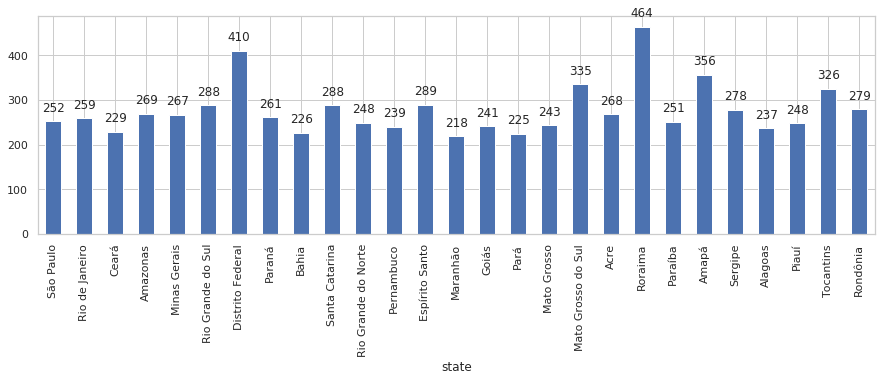

In [965]:
df_tests_cases['tests_100k'] = df_tests_cases['total_tests'] / df_tests_cases['population'] * 100000
df_tests_cases['tests_100k'].plot(kind='bar', figsize=(15,4))
# df_tests_cases
ys = df_tests_cases['tests_100k']
xs = range(0,len(ys))
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.savefig('img/tests_100k')

In [988]:
us_daily_url = 'https://covidtracking.com/api/us/daily.csv'
us_covid = pd.read_csv(us_daily_url)
us_covid['date'] = pd.to_datetime(us_covid['date'], format='%Y%m%d')
print(us_covid['date'].max())
us_covid = us_covid.set_index('date', drop = True)
us_covid = us_covid.sort_values(by = 'date', ascending = True)
us_covid['new_cases'] = us_covid['positive'].diff().fillna(0)
us_data = us_covid.copy()
us_data.loc[str_today]

2020-04-06 00:00:00


states                                                            56
positive                                                      361331
negative                                                     1555764
pending                                                        17292
hospitalizedCurrently                                      27675.000
hospitalizedCumulative                                     45168.000
inIcuCurrently                                              6607.000
inIcuCumulative                                              971.000
onVentilatorCurrently                                       2932.000
onVentilatorCumulative                                       187.000
recovered                                                  16006.000
hash                        206c757b1b311a9be1cd19c90c9782422a421a55
dateChecked                                     2020-04-06T20:00:00Z
death                                                          10680
hospitalized                      

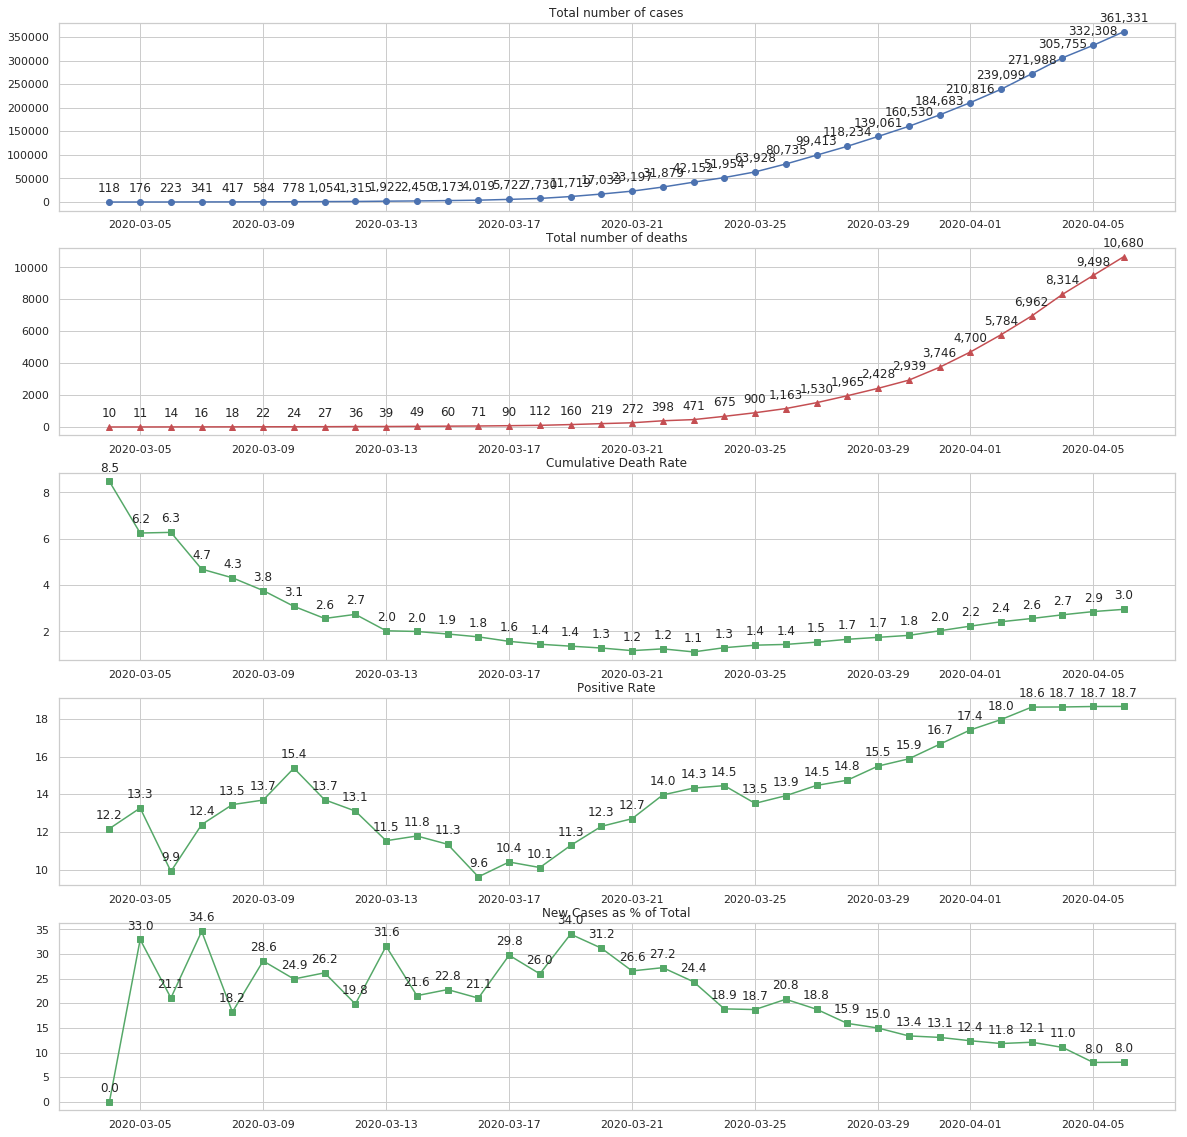

In [989]:
plt.figure(figsize = (20,20))

# plt.gca().title('Italian Cases')

plt.subplot('511')
xs = us_data.index.values
ys = us_data['positive']
plt.gca().set_title('Total number of cases')
plt.plot(xs, ys, 'bo-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('512')
plt.gca().set_title('Total number of deaths')
ys = us_data['death']
plt.plot(xs, ys, 'r^-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('513')
plt.gca().set_title('Cumulative Death Rate')
ys = us_data['death'] / us_data['positive'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('514')
plt.gca().set_title('Positive Rate')
ys = us_data['positive'] / us_data['total'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('515')
plt.gca().set_title('New Cases as % of Total')
ys = us_data['new_cases'] / us_data['positive'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.savefig('./img/us_overview')
plt.show()

In [990]:
states_daily_url = 'http://covidtracking.com/api/states/daily.csv'
us_covid_state = pd.read_csv(states_daily_url)
us_covid_state['date'] = pd.to_datetime(us_covid_state['date'], format='%Y%m%d')
# us_covid_state = us_covid_state.set_index('date', drop = True)
ny_covid = us_covid_state[us_covid_state['state'] == 'NY']
ny_covid = ny_covid.sort_values(by='date')
ny_covid['new_cases'] = ny_covid['positive'].diff().fillna(0)
ny_data = ny_covid.copy()
# ny_data

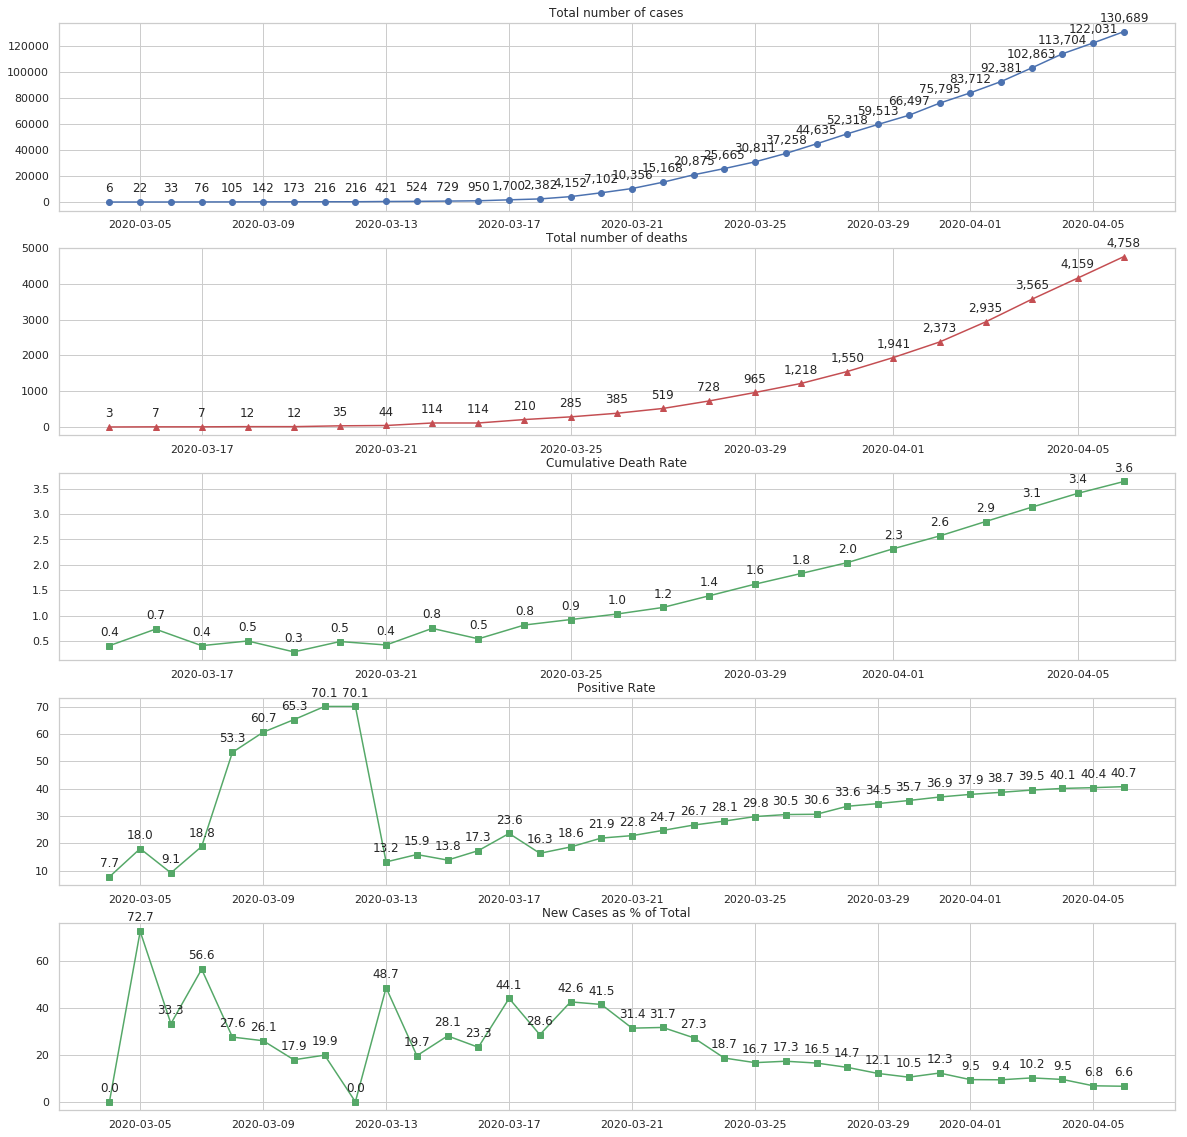

In [991]:
plt.figure(figsize = (20,20))

# plt.gca().title('Italian Cases')

plt.subplot('511')
xs = ny_data['date']
ys = ny_data['positive']
plt.gca().set_title('Total number of cases')
plt.plot(xs, ys, 'bo-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('512')
plt.gca().set_title('Total number of deaths')
ys = ny_data['death']
plt.plot(xs, ys, 'r^-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('513')
plt.gca().set_title('Cumulative Death Rate')
ys = ny_data['death'] / ny_data['positive'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('514')
plt.gca().set_title('Positive Rate')
ys = ny_data['positive'] / ny_data['total'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('515')
plt.gca().set_title('New Cases as % of Total')
ys = ny_data['new_cases'] / ny_data['positive'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.savefig('./img/ny_overview')
plt.show()

In [992]:
us_covid_state['rel_date'] = (dt.datetime.now() - pd.to_datetime(us_covid_state['date'])).dt.days
us_covid_state = us_covid_state.set_index('date', drop = True)
us_covid_state['known'] = HDT(us_covid_state['rel_date'])
us_covid_state['known_cases'] = us_covid_state['known'] * us_covid_state['positive']
# us_covid_state

In [993]:
us_known_cases = us_covid_state.pivot_table(values = 'known_cases', index = 'state', columns = 'date', aggfunc = 'sum').fillna(0).cumsum(axis = 1)
us_deaths = us_covid_state.pivot_table(values = 'death', index = 'state', columns = 'date', aggfunc = 'sum').cumsum(axis = 1).fillna(0)
us_deaths = us_deaths[us_deaths[str_today] > 10]
us_death_rate = (us_deaths / us_known_cases * 100).fillna(0)
us_death_rate = us_death_rate[us_death_rate[str_today] > 0]

In [994]:
us_reported = (3.2 / us_death_rate * 100).replace(np.inf, np.nan)
us_reported = us_reported[us_reported.columns[-4:]].sort_values(by = str_today, ascending = False)
# us_reported

In [995]:
us_state = us_covid_state[us_covid_state.index == str_today].set_index('state', drop = True)
us_state['positive_rate'] = us_state['positive'] / us_state['total'] * 100
us_state['death_rate'] = us_state['death'] / us_state['positive'] * 100
us_state = us_state.fillna(0)

us_state_data = pd.read_csv('us_states_data.csv')
us_state_data.columns = ['state', 'population','area-miles', 'area']
us_state_data['population'] = us_state_data['population'].str.replace(',','').astype(int)
us_state_data['area-miles'] = us_state_data['area-miles'].str.replace(',','').astype(int)
us_state_data['area'] = us_state_data['area'].str.replace(',','').astype(int)
us_state_data['density'] = us_state_data['population'].astype(float) / us_state_data['area'].astype(float)
us_state_data = us_state_data.set_index('state', drop = True)

us_state = us_state.merge(us_state_data, on='state')
us_state['tests_per_1000'] = us_state['total'] / us_state['population'] * 1000
us_state['positive_per_1000'] = us_state['positive'] / us_state['population'] * 1000

In [996]:
# us_state.sort_values(by='positive_rate', ascending=False)
df_corr = us_state[['tests_per_1000','positive_per_1000','positive_rate','death_rate','density']].sort_values(by='tests_per_1000', ascending=False).corr()

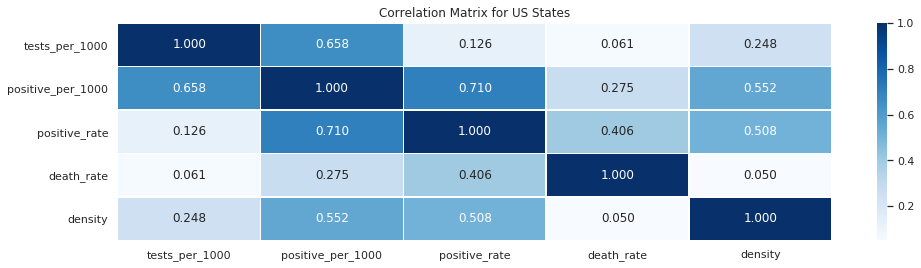

In [997]:
plt.figure(figsize = (16,4))
title = 'Correlation Matrix for US States'
# df_result = df_count.div(df_count.sum(axis = 0).sum(), axis = 1) * 100
plt.title(title)
sns.heatmap(df_corr, annot = True, linewidths = 0.5, cmap='Blues', fmt=',.3f')
plt.savefig('./img/' + title)